Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib

In [2]:

print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


Get Data Set and Display it

In [ ]:
data = pd.read_csv("../Data/005930.KS.csv")

df = data.copy()

#Plotting the Price Data (using Adj Close as the primary example)
plt.style.use('bmh')  # Using a more visually structured style
#plt.style.use('petroff10')  # Using a more visually structured style

plt.figure(figsize=(12, 6))
plt.plot(df['Adj Close'], label='Adj Close Price', color='royalblue', linewidth=2)

plt.title('Adjusted Close Price Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adj Close Price', fontsize=14)

plt.legend(fontsize=12)
plt.grid(True, linestyle=':', linewidth=0.8)

plt.show()

df.dropna(inplace=True)

df.info()

OSError: 'petroff10' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

Processing

In [ ]:
# Split original dataset into training and test sets while preserving original scale
train_size = int(0.8 * len(data))
train_data_original = df[:train_size]
test_data_original = df[train_size:]

# Scale features and target using MinMaxScaler
scaler_features = MinMaxScaler()
features_scaled = scaler_features.fit_transform(data[['Open', 'High', 'Low', 'Volume']])

features = df[['Open', 'High', 'Low', 'Volume']]


scaler_target = MinMaxScaler()
target_scaled = scaler_target.fit_transform(data[['Adj Close']])

# Split scaled data into train and test sets
X_train = features_scaled[:train_size]
X_test = features_scaled[train_size:]
y_train = target_scaled[:train_size]
y_test = target_scaled[train_size:]

joblib.dump(scaler_features, "../Artifact/scaler_X_daily.pkl")
joblib.dump(scaler_target, "../Artifact/scaler_y_daily.pkl")

['../Artifact/scaler_y_daily.pkl']

Build Nueral Network

In [ ]:
model = Sequential()
model.add(Dense(128, input_dim=features.shape[1], activation='relu'))  # Input layer
model.add(Dense(64, activation='relu'))  # Hidden layer
model.add(Dense(1, activation='linear'))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

c:\Users\ruanl\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Train Model

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0341 - mae: 0.1112 - val_loss: 0.0069 - val_mae: 0.0791
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7803e-04 - mae: 0.0222 - val_loss: 0.0048 - val_mae: 0.0646
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3254e-04 - mae: 0.0210 - val_loss: 0.0055 - val_mae: 0.0703
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3711e-04 - mae: 0.0212 - val_loss: 0.0074 - val_mae: 0.0836
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0450e-04 - mae: 0.0191 - val_loss: 0.0071 - val_mae: 0.0809
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3804e-04 - mae: 0.0190 - val_loss: 0.0033 - val_mae: 0.0539
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3510e-04 - mae: 0.0215 - val_loss: 0.0080 - val_mae: 0.0866
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0232e-04 - mae: 0.0202 - val_loss: 0.0060 - val_mae: 0.0733
Epoch 9/50
151/151 ━━━━━━━━━

Predict

In [ ]:

predictions_scaled = model.predict(X_test)
predictions_original = scaler_target.inverse_transform(predictions_scaled)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [ ]:
num_future_steps = 30  # Number of days to predict into the future
future_predictions_scaled = []
future_predictions_original = []

# Use the last training data and the test predictions to start the iterative process
last_known_features_scaled = X_test[-1:].copy() # shape (1, 4)

for _ in range(num_future_steps):
    # Predict the next step
    next_prediction_scaled = model.predict(last_known_features_scaled)
    next_prediction_original = scaler_target.inverse_transform(next_prediction_scaled)

    # Store the prediction
    future_predictions_scaled.append(next_prediction_scaled[0][0])
    future_predictions_original.append(next_prediction_original[0][0])

    # Update last_known_features_scaled for the next iteration
    new_features_scaled = last_known_features_scaled.copy()
    new_features_scaled[0, 0] = new_features_scaled[0, 1] # Open = High
    new_features_scaled[0, 1] = new_features_scaled[0, 2] # High = Low
    new_features_scaled[0, 2] = next_prediction_scaled[0][0] # Low = Predicted Adj Close
    new_features_scaled[0, 3] = new_features_scaled[0, 3]
    last_known_features_scaled = new_features_scaled



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

Evaluate the model

In [ ]:
def calculate_accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Handle cases with zero values in y_true to avoid division by zero
    if np.any(y_true == 0):
        print("Warning: Actual values contain zeros. MAPE and accuracy are undefined.")
        return 0.0  

    # Calculate absolute percentage errors
    absolute_percentage_errors = np.abs((y_true - y_pred) / y_true) * 100

    # Calculate MAPE
    mape = np.mean(absolute_percentage_errors)

    # Calculate accuracy
    accuracy = 100 - mape

    return accuracy

In [ ]:

print(f'Accuracy: {calculate_accuracy(y_test,predictions_scaled):.2f}%')


Accuracy: 85.94%


Save Model

In [ ]:
# 7. Save the model
model.save('Daily_stock_price_prediction_model_2.h5')  # Save the model in .h5 format
print("Model saved to Daily_stock_price_prediction_model_2.h5")

Model saved to Daily_stock_price_prediction_model_2.h5


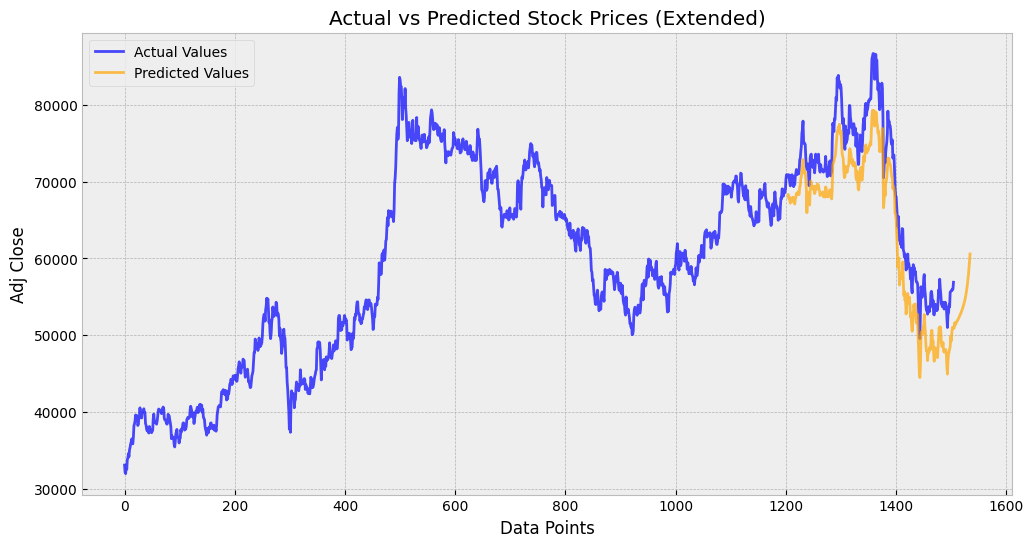

In [ ]:
all_predictions_original = np.concatenate([predictions_original.flatten(), future_predictions_original])
all_actual_original = df['Adj Close'].values

plt.figure(figsize=(12, 6))
plt.plot(all_actual_original, label="Actual Values", color="blue", alpha=0.7)
plt.plot(range(train_size, train_size + len(all_predictions_original)), all_predictions_original, label="Predicted Values", color="orange", alpha=0.7)
plt.xlabel("Data Points")
plt.ylabel("Adj Close")
plt.title("Actual vs Predicted Stock Prices (Extended)")
plt.legend()
plt.grid(True)
plt.show()